In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pygam
from sklearn import tree
from pyearth import Earth

import lib_PRIM as prim

# Exercise 9.6

Consider the ozone data of Figure 6.9.

(a) Fit an additive model to the cube root of ozone concentration. as a function of temperature, wind speed, and radiation. Compare your results to those obtained via the trellis display in Figure 6.9.

(b) Fit trees, MARS, and PRIM to the same data, and compare the results to those found in (a) and in Figure 6.9.

# Solution

Some useful functions for the notebook,

In [2]:
def standardize(X):
    mu = np.mean(X,axis=0)
    sig = np.std(X,axis=0)
    
    return (X-mu)/sig

def cross_validation_splitting(X,y,K):
    
    N,_ = X.shape
    delta = N//K
    
    output = []
    
    for i in range(K):
        X_train = np.concatenate((X[:i*delta],X[(i+1)*delta:]))
        y_train = np.concatenate((y[:i*delta],y[(i+1)*delta:]))
        
        X_val = X[i*delta:(i+1)*delta]
        y_val = y[i*delta:(i+1)*delta]
        
        output.append((X_train,y_train,X_val,y_val))
        
    return output

def MSE(y_exp,y_pred):
    return np.mean((y_exp-y_pred)**2)

In [3]:
url_link = 'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/ozone.data'
df_ozone = pd.read_csv(url_link,sep='\t')
df_ozone['ozone'] = df_ozone['ozone'].apply(np.cbrt)

df_ozone.tail()

,ozone,radiation,temperature,wind
106,2.410142,20,63,16.6
107,3.107233,193,70,6.9
108,2.410142,191,75,14.3
109,2.620741,131,76,8.0
110,2.714418,223,68,11.5


In [4]:
y = df_ozone.pop('ozone').to_numpy()
X = df_ozone.to_numpy()
X = standardize(X)

# Get features name
feat_name = list(df_ozone)

## Additive model

In [5]:
# Create a grid of smoothing values to optimize the fitting
lambda_range = np.logspace(-3, 5, 10)
lambdas_grid = [lambda_range] * 3

# Create the additive model (each term is considered individually, fitted by a cubic spline)
gam = pygam.LinearGAM(terms = pygam.s(0) + pygam.s(1) + pygam.s(2))

# Use Generalized Cross-Validation for deciding the optimal smoothing
gam.gridsearch(X,y, lam=lambdas_grid)
gam.summary()

100% (1000 of 1000) |####################| Elapsed Time: 0:00:24 Time:  0:00:24


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      8.5227
Link Function:                     IdentityLink Log Likelihood:                                  -173.9409
Number of Samples:                          111 AIC:                                              366.9272
                                                AICc:                                             368.9218
                                                GCV:                                                0.2413
                                                Scale:                                              0.2082
                                                Pseudo R-Squared:                                   0.7554
Feature Function                  Lam

C:\Users\Carlo Sparaciari\Anaconda3\envs\ml_env\lib\site-packages\ipykernel_launcher.py:10: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  # Remove the CWD from sys.path while we load stuff.


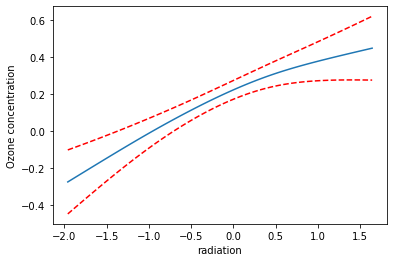

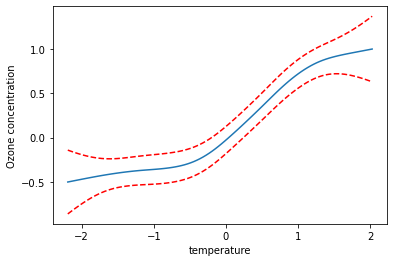

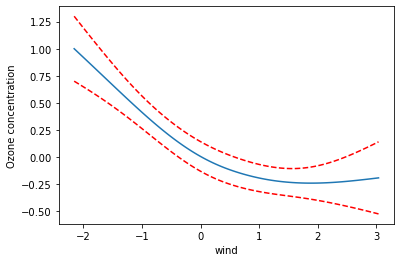

In [6]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    X_grid = gam.generate_X_grid(term=i)
    X_line = X_grid[:,i]
    pdep, confi = gam.partial_dependence(term=i, X=X_grid, width=0.95)

    plt.plot(X_line, pdep)
    plt.plot(X_line, confi, c='r', ls='--')
    plt.xlabel(feat_name[i])
    plt.ylabel('Ozone concentration')
    plt.show()

## Trees

Regression trees from https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html

In [9]:
K = 5
terminal_nodes = np.arange(2,11,1,dtype=np.int)
cross_val = cross_validation_splitting(X,y,K)

train_error = []
val_error = []
val_error_se = []

for num_nodes in terminal_nodes:
    mod = tree.DecisionTreeRegressor(max_leaf_nodes=num_nodes)
    train_error_fixed_nodes = []
    val_error_fixed_nodes = []
    
    for X_train,y_train,X_val,y_val in cross_val:
        mod.fit(X_train,y_train)
        
        y_pred_train = mod.predict(X_train)
        train_error_fixed_nodes.append(MSE(y_train,y_pred_train))
        
        y_pred_val = mod.predict(X_val)
        val_error_fixed_nodes.append(MSE(y_val,y_pred_val))
        
    train_error.append(np.mean(train_error_fixed_nodes))
    val_error.append(np.mean(val_error_fixed_nodes))
    val_error_se.append(np.std(val_error_fixed_nodes)/np.sqrt(K))

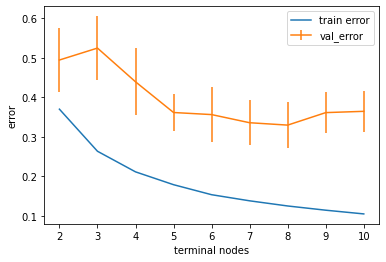

In [10]:
plt.plot(terminal_nodes,train_error,label='train error')
plt.errorbar(terminal_nodes,val_error,yerr=val_error_se,label='val_error')
plt.xlabel('terminal nodes')
plt.ylabel('error')
plt.legend()
plt.show()

Using the 1 standard deviation rule (pick the least complex model within one standard deviation form the optimal one), we should use the one with 4 terminal nodes.

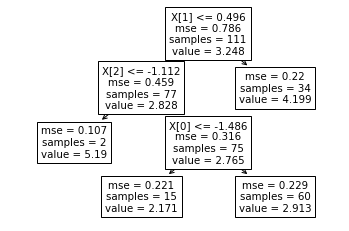

In [9]:
opt_num_nodes = 4

opt_tree = tree.DecisionTreeRegressor(max_leaf_nodes=opt_num_nodes)
opt_tree.fit(X,y)

tree.plot_tree(opt_tree)
plt.show()

We recall that,
- feature 0 : radiation
- feature 1 : temperature
- feature 2 : wind

## MARS

Multivariate Adaptive Regression Splines code at https://contrib.scikit-learn.org/py-earth/content.html

In [10]:
# Use https://contrib.scikit-learn.org/py-earth/content.html
mars = Earth()
mars.fit(X,y,xlabels=feat_name)

#Print the model
print(mars.summary())

Earth Model
---------------------------------------------
Basis Function          Pruned  Coefficient  
---------------------------------------------
(Intercept)             No      3.54967      
temperature             Yes     None         
h(wind-1.40024)         Yes     None         
h(1.40024-wind)         No      0.334913     
radiation               Yes     None         
h(radiation-0.178511)   Yes     None         
h(0.178511-radiation)   No      -0.31605     
h(radiation+0.526795)   Yes     None         
h(-0.526795-radiation)  Yes     None         
h(radiation+0.802305)   Yes     None         
h(-0.802305-radiation)  Yes     None         
h(temperature-1.39215)  Yes     None         
h(1.39215-temperature)  No      -0.444526    
h(radiation-0.994021)   Yes     None         
h(0.994021-radiation)   Yes     None         
---------------------------------------------
MSE: 0.2307, GCV: 0.2706, RSQ: 0.7063, GRSQ: 0.6618


C:\Users\Carlo Sparaciari\Anaconda3\envs\ml_env\lib\site-packages\pyearth\earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
C:\Users\Carlo Sparaciari\Anaconda3\envs\ml_env\lib\site-packages\pyearth\earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


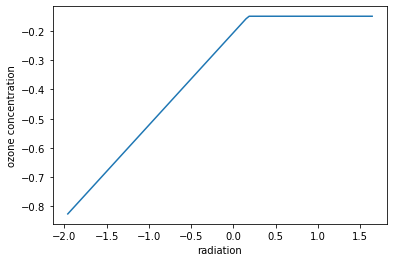

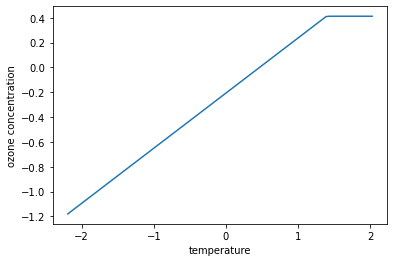

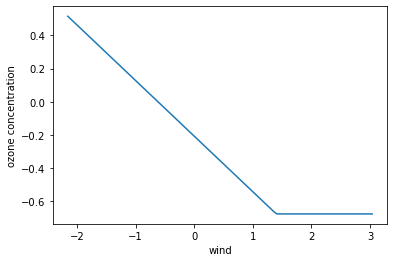

In [11]:
# To visualize the different basis functions, we remove the intercept from the predictions
intercept = mars.coef_[0,0]
for i in range(0,3):
    # We use this method from GAM to generate a grid with only one non-zero feature
    X_grid = gam.generate_X_grid(term=i)
    X_line = X_grid[:,i]
    
    y_pred = mars.predict(X_grid) - intercept
    
    plt.plot(X_line,y_pred)
    plt.xlabel(feat_name[i])
    plt.ylabel('ozone concentration')
    plt.show()

It is easy to see how these hinge functions are a good approximation of the smoothing splines used in the additive model above!

## PRIM

I could only find one implementation of PRIM for python on github, and it was not really used. So I decided to implement the algorithm myself, see the library file in the directory.

Let's use the PRIM algorithm to obtain three boxes where the ozone density is maximum

In [12]:
boxes = prim.PRIM(X,y,num_boxes=2,use_cv=False)
N,features = X.shape

# Print a summary of the resulting boxes
for i,box in enumerate(boxes):
    contained = prim.contained_observations(X,box)
    N_box = np.sum(contained)
    y_average = np.mean(y[contained])
    print('--- Box {} ---'.format(i+1))
    print('Ozone concentration = {:.2f}'.format(y_average))
    for p in range(features):
          print('Feature : {} - x_min = {:.2f} , x_max = {:.2f}'.format(feat_name[p],box[p],box[features+p]))
    print('Coverage = {:.2f}'.format(N_box/N))

--- Box 1 ---
Ozone concentration = 4.72
Feature : radiation - x_min = -0.02 , x_max = 0.96
Feature : temperature - x_min = 0.13 , x_max = 2.02
Feature : wind - x_min = -2.16 , x_max = -1.20
Coverage = 0.09
--- Box 2 ---
Ozone concentration = 4.41
Feature : radiation - x_min = -0.20 , x_max = 0.99
Feature : temperature - x_min = 0.76 , x_max = 2.02
Feature : wind - x_min = -1.03 , x_max = -0.38
Coverage = 0.09


## Plotting GAM and PRIM together

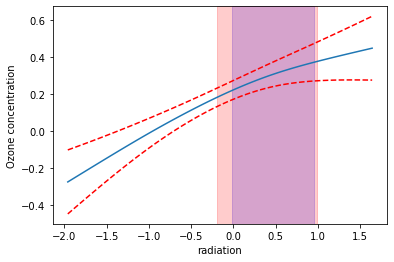

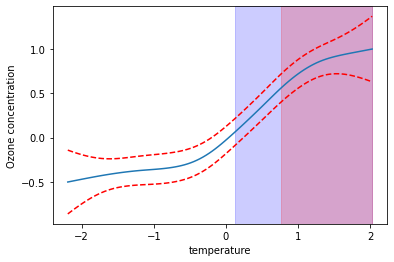

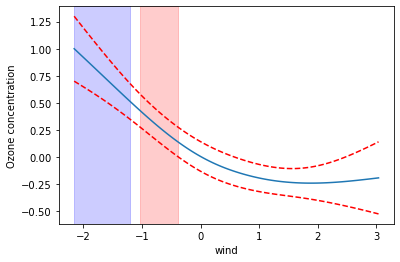

In [13]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    X_grid = gam.generate_X_grid(term=i)
    X_line = X_grid[:,i]
    pdep, confi = gam.partial_dependence(term=i, X=X_grid, width=0.95)
    
    col = ['b','r']

    plt.plot(X_line, pdep)
    plt.plot(X_line, confi, c='r', ls='--')
    for box,c in zip(boxes,col):
        plt.axvspan(box[i],box[features+i], color=c, alpha=0.2)
    plt.xlabel(feat_name[i])
    plt.ylabel('Ozone concentration')
    plt.show()